In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, race/ethnicity, parental level of education, lunch, test pr...
dbl (3): math score, reading score, writing score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


parental_level_of_education,math_score,reading_score,writing_score,mean_score
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
associate's degree,65,79,84,76
some college,54,70,65,63
some college,76,83,78,79
⋮,⋮,⋮,⋮,⋮
some college,63,64,69,65.33333
high school,65,81,69,71.66667
some college,81,79,80,80.00000


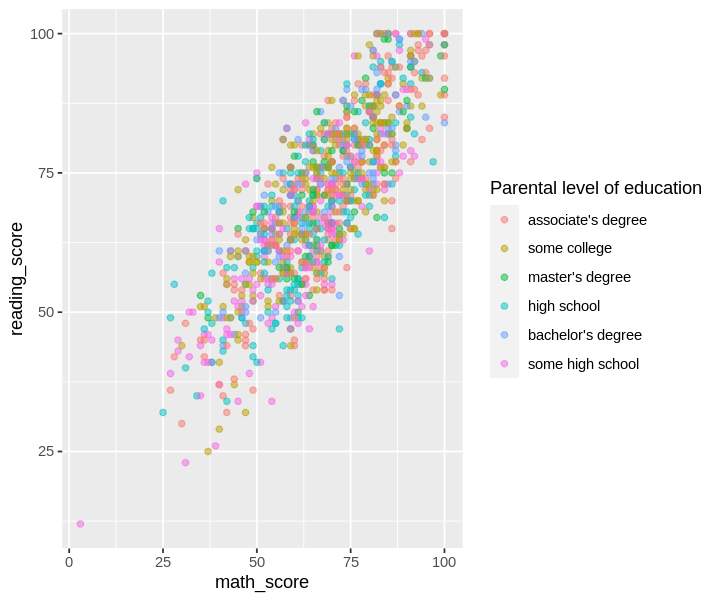

In [6]:
url <- "http://roycekimmons.com/system/generate_data.php?dataset=exams&n=1000"
exam_data <- read_csv(url)
colnames(exam_data) <- c("gender", "race_ethnicity", "parental_level_of_education", "lunch", "test_preparation_course", 
                         "math_score", "reading_score", "writing_score")
exam_data1<- exam_data |>
mutate(parental_level_of_education = as_factor(parental_level_of_education)) |>
mutate("mean_score" = (math_score + reading_score + writing_score)/3) |>
select(parental_level_of_education, math_score, reading_score, writing_score, mean_score)

exam_data1

exam_graph <- exam_data1 |>
ggplot(aes(x = math_score, y = reading_score, color = parental_level_of_education)) +
geom_point(alpha = 0.5) +
labs(color = "Parental level of education")

exam_graph

#exam_graph <- exam_data1 |>
#ggplot(aes(x = mean_score, y = fct_reorder(parental_level_of_education, mean_score, .desc = TRUE), 
#           fill = parental_level_of_education)) +
#geom_bar(stat = "identity") + 
#labs(x = "Average Score", y = "Parental Level of Education",  fill = "type")

data_split <- initial_split(exam_data1, prop = 0.75, strata = parental_level_of_education)
data_train <- training(data_split)
data_test <- testing(data_split)

data_recipe <- recipe(parental_level_of_education ~ math_score + reading_score + writing_score, data = data_train) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.1712010,5,0.01821666,Preprocessor1_Model01
2,accuracy,multiclass,0.1698765,5,0.01848569,Preprocessor1_Model02
3,accuracy,multiclass,0.1684715,5,0.01633619,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,multiclass,0.1761768,5,0.01175361,Preprocessor1_Model08
9,accuracy,multiclass,0.1909075,5,0.01130748,Preprocessor1_Model09
10,accuracy,multiclass,0.1856631,5,0.01047492,Preprocessor1_Model10


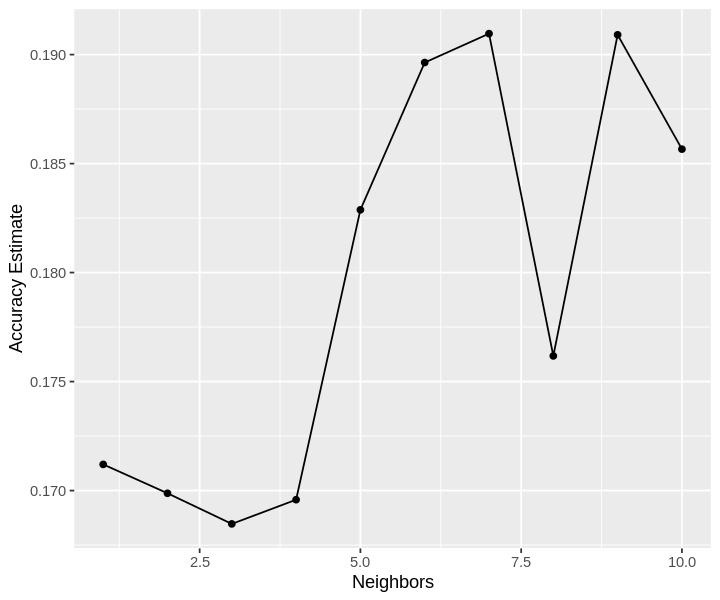

In [5]:
set.seed(1234) 
options(repr.plot.height = 5, repr.plot.width = 6)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10))
vfold <- vfold_cv(data_train, v = 5, strata = parental_level_of_education)
recipe <- recipe(parental_level_of_education ~., data = data_train)

knn_results <- workflow() |>
add_recipe(recipe) |>
add_model(knn_spec)|>
tune_grid(resamples = vfold, grid = k_vals) |>
collect_metrics()

accuracies <- knn_results |>
filter(.metric == "accuracy")

accuracies

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate")

cross_val_plot